<h1><center>MAPD mod. B</center><a class="tocSkip"></h1>

**Authors**
- Marco Ballarin (1228022)
- Francesco Manzali (1234428)
- Beatrice Segalini (1234430)

**Natural language processing**

Natural language processing is a complex field of linguistics and computer science. It basically study ways to make the computer understand and analyze natural language.

It is really important nowadays because with the digital era lots of information are available on the internet, but they are too much to be analyzed by humans. 

In particular the spread of the pandemic COVID19 has led to a spread of publications about it. It is so really difficoult to find the topic a reasercher is looking for, and an automatic analysis is needed. 

In this work we will tackle the problem of a preliminary analysis on a dataset of $1000$  COVID19 papers, using the dask package.

## Word Counter

First of all, you have to implement the following distributred algorithm to *count* the occurrences of all the words inside a list of documents. In NLP (Natural Language Processing) a document is a text; in this case, each paper is a document.

The algorithm is defined as follows:

- **Map phase**: For each document $D_i$, produce the set of intermediate pairs $(w, \mathrm{cp}_i(w))$, one for each word $w \in D_i$, where $\mathrm{cp}_i(w)$ is the number of occurrences of $w$ in $D_i$. E.g. $('\mathrm{hello}', 3)$.
- **Reduce phase**: For each word $w$, gather all the previous pairs $(w, \mathrm{cp}_i(w))$ and return the final pair $(w, \mathrm{c}(w))$ where $\mathrm{c}(w)$ is the number of occurrences of $w$ for all the documents. In other words:
$$ \mathrm{c}(w) = \sum_{k=1}^n \mathrm{cp}_k(w)$$


1. The algorithm has to be run on the **full-text** of the papers. To get the full text of a paper you have to transform the input data by concatenating the strings contained in the *body-text* fields of the JSON. To perform this transformation I strongly suggest you use the Bag data-structure of DASK. Anyway, if you prefer to implement the algorithm by using the DataFrame structure feel free to do it.

2. The algorithm has to be run several times by changing the *number of workers* and the *number of partitions*. For each run the **execution time** must be registered. Provide a comment on how the computation time over the cluster varies by changing the number of partitions/workers. You have to try with at least $6$ different partition numbers.

3. At the end of the algorithm, analyze the **top words** and see how they are related to viruses and research (for example create a barplot of the top words).


In [1]:
from dask.distributed import Client, LocalCluster
import dask.bag as db

import os
import json
import glob 

# Needed first time you use nltk
# import nltk as nlt
# nlt.download('stopwords')
import re
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import bokeh.palettes as palette
import seaborn as sn
import pandas as pd

from itertools import islice
import time 
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import io

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36383 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 16.82 GB


In [3]:
PATH = os.path.join('data', 'papers_in_json', '*.json')

js = db.read_text(PATH).map(json.loads)

In [4]:
def joiner(paper):
    """
    Joins the paragraphs inside the "body_text" forming a unique string.
    """
    
    return ''.join([paragraph['text'] for paragraph in paper['body_text']])

#Regex for "filtering" a string
rm_word    = ['also', 'may', 'et' , 'using', 'used', 'al', 'two', 'one', 'e', 'could', 'use']
stopw      = stopwords.words('english') + rm_word
citations  = re.compile('\[[\d]+\]')
numbers    = re.compile('((^|\s)[\d]+)')
fixpoints  = re.compile('([\.,:?;!](?=\w))')
urls       = re.compile('(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)')
pattern    = re.compile('[^a-zA-Z\d\s]')
spaces     = re.compile('\s([\s]+)')
stop_words = re.compile(r'\b(' + r'|'.join(stopw) + r')\b\s*')


def sanitize_string(s):
    """
    Remove all non-necessary characters/words from a string @s.
    """
    
    # Transform all capital letters in lower letters
    sanitized_string = s.lower()
    
    # Remove urls
    sanitized_string = urls.sub('', sanitized_string)
    
    # Remove citations of the type [x] where x is a number
    sanitized_string = citations.sub('', sanitized_string)
    
    # Insert spacing after puntuations 
    sanitized_string = fixpoints.sub(' ', sanitized_string)
    
    # Remove puntuation
    sanitized_string = pattern.sub('', sanitized_string)
    
    # Remove single numbers
    sanitized_string = numbers.sub('', sanitized_string)
    
    # Remove multiple spacing
    sanitized_string = spaces.sub('', sanitized_string)
    
    # Removing stopwords or words that aren't interesting to the analysis
    sanitized_string = stop_words.sub('', sanitized_string)
    
    return sanitized_string

In [5]:
def count_words(s):
    """
    Given a string @s, return a dictionary of { word : number_of_occurrences }
    """
    
    wordlist = {}
    
    for word in s.split():
        if word in wordlist:
            wordlist[word] += 1
        else:
            wordlist[word] = 1
        
    return wordlist

In [6]:
#Applies the above functions to the dataset (Map step)
js = js.map(joiner).map(sanitize_string).map(count_words)

In [7]:
def merge_dictionaries(x, y):
    """
    Given two dictionaries @x, @y, return their sum "x + y", i.e. a dictionary such that:
    - each key of "x + y" is present in x or y (or both)
    - the value of each key in "x + y" is the sum of the values the same key had in x and y.
      (using 0 if it was not present in one of them)
    """
    
    return {k: x.get(k, 0) + y.get(k, 0) for k in set(x) | set(y)}

#Reduce step
reduction = js.fold(binop=merge_dictionaries, combine=merge_dictionaries)

In [8]:
words_dictionary = reduction.compute()

In [9]:
#Sort the words by number of occurrences (decreasing)
words_count = {k: v for k, v in sorted(words_dictionary.items(), key=lambda item: item[1], reverse=True)}

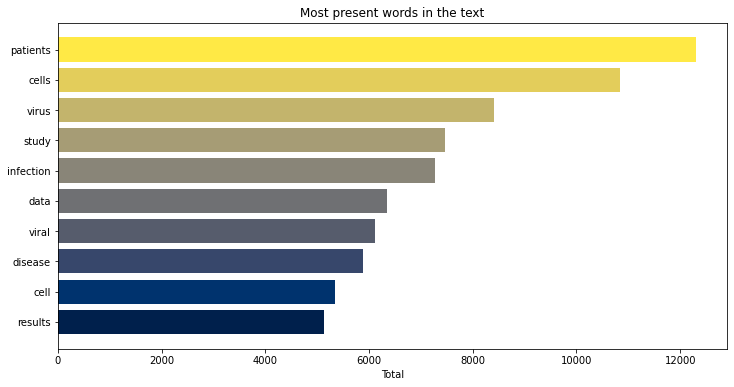

In [10]:
# Show the 10 most frequent words
idx = 10

best_words = dict( islice(words_count.items(), idx))

f, ax = plt.subplots(figsize=(12, 6))

ax.barh(list(best_words.keys())[::-1], list(best_words.values())[::-1], 
        color=palette.cividis(idx) )
ax.set_xlabel('Total')
ax.set_title('Most present words in the text')

plt.show()

In [11]:
client.close()

In [12]:
# GRIDSEARCH - TIME ANALYSIS

def compute_time(n_workers, n_partitions):
    """
    Executes all the previous steps for a given choice of @n_workers and @n_partitions
    
    Return: computed time
    """
    
    cluster = LocalCluster(n_workers = n_workers)
    client = Client(cluster) 
    
    start = time.time() 
        
    PATH = os.path.join('data', 'papers_in_json', '*.json')

    js = db.read_text(PATH).map(json.loads)
    js = js.repartition(n_partitions)
    
    js = js.map(joiner).map(sanitize_string).map(count_words)
    
    reduction = js.fold(binop=merge_dictionaries, combine=merge_dictionaries)
    
    a = reduction.compute()
    words_count = {k: v for k, v in sorted(a.items(), key=lambda item: item[1], reverse=True)}

    end = time.time()
    
    client.close()
    cluster.close() 
    
    computed_time = end - start
    
    return computed_time

In [13]:
from tqdm.notebook import tqdm

workers = [1, 2, 4, 8]
partitions = [1, 5, 25, 50, 75, 100]

times = []

for w in tqdm(workers):
    for p in tqdm(partitions):
        t = compute_time(n_workers = w, n_partitions = p*w)
        times.append(t)
        print("Workers=", w, "Partitions=", p*w, "Time=", t,"s")

Workers= 1 Partitions= 1 Time= 83.03283500671387 s
Workers= 1 Partitions= 5 Time= 50.387670278549194 s
Workers= 1 Partitions= 25 Time= 39.849358797073364 s
Workers= 1 Partitions= 50 Time= 38.876835346221924 s
Workers= 1 Partitions= 75 Time= 40.31889033317566 s
Workers= 1 Partitions= 100 Time= 41.27193999290466 s



Workers= 2 Partitions= 2 Time= 41.379939794540405 s
Workers= 2 Partitions= 10 Time= 25.581279039382935 s
Workers= 2 Partitions= 50 Time= 22.95245909690857 s
Workers= 2 Partitions= 100 Time= 22.802624702453613 s
Workers= 2 Partitions= 150 Time= 23.79192543029785 s
Workers= 2 Partitions= 200 Time= 22.989927053451538 s



Workers= 4 Partitions= 4 Time= 19.23916745185852 s
Workers= 4 Partitions= 20 Time= 13.764354467391968 s
Workers= 4 Partitions= 100 Time= 13.261164903640747 s
Workers= 4 Partitions= 200 Time= 14.054314374923706 s
Workers= 4 Partitions= 300 Time= 14.47996211051941 s
Workers= 4 Partitions= 400 Time= 15.120329856872559 s



Workers= 8 Partitions= 8 Time= 11.502245903015137 s
Workers= 8 Partitions= 40 Time= 8.975571155548096 s
Workers= 8 Partitions= 200 Time= 9.477815628051758 s
Workers= 8 Partitions= 400 Time= 10.43550968170166 s
Workers= 8 Partitions= 600 Time= 10.695342779159546 s
Workers= 8 Partitions= 800 Time= 10.878952741622925 s




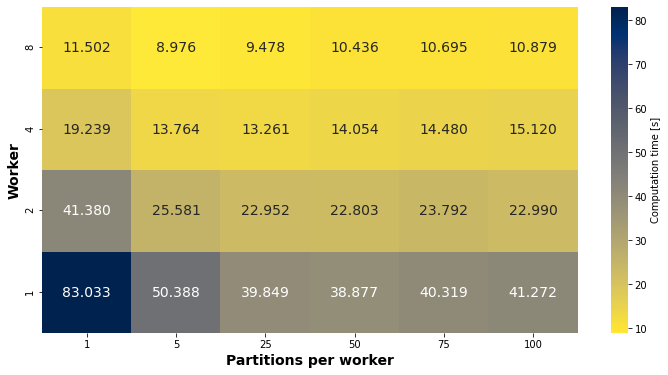

In [14]:
#Plot the grid search results
time_plot = np.array(times).reshape(len(workers), len(partitions))

df_times = pd.DataFrame(time_plot)

plt.figure(figsize=(12,6))

ax = sn.heatmap(df_times, annot=True, annot_kws={"size": 14},fmt=".3f",
                xticklabels=partitions, yticklabels=workers,
                cbar_kws={'label':'Computation time [s]'},cmap='cividis_r' )
ax.invert_yaxis()
ax.set_xlabel("Partitions per worker", fontsize=14, fontweight='bold')
ax.set_ylabel("Worker", fontsize=14, fontweight='bold')

plt.show()

We see that increasing the number of workers leads to a better performance. The optimal number of partitions is found to be around $25$.

## Worst and Best represented Countries
1. In this part you have to take the documents and convert them in a usable *DataFrame* data structure in order to figure out the countries that are most and less active in the research. To do this you can use the country of the authors. Do the same for the universities (affiliations).

2. Even in this case, do multiple runs by changing the *number of partitions* and *workers* and then describe the behaviour of the timings.

In [15]:
PATH = os.path.join('data', 'papers_in_json', '*.json')

js = db.read_text(PATH).map(json.loads)


def reformat(paper):
    """
    Extract from data the following fields: "paper_id", "author" (first + last name), 
    "institution" and "country".
    """
    
    metadata = paper['metadata'] #dictionary
    
    dataframe = []
    
    for author in metadata['authors']:

        a = author['affiliation']
        
        try:
            country = a['location']['country']
            if  len(country)==0: # When country = {}
                country = 'Missing'
        except KeyError:
            try: # Try different position of the country
                country = a['location']['region']
            except KeyError:
                try:
                    country = a['location']['settlements']
                except KeyError:
                    country = 'Missing'
        
        try:
            institution = a['institution']
            if  len(institution)==0: # When institution = {}
                institution = 'Missing'
        except KeyError:
            institution = 'Missing'
            
        # We only store the informations that are interesting for our analysis
        dataframe.append(
            {
                'id' : paper['paper_id'],
                'author' : author['first'] + ' ' + author['last'],
                'country' : country,
                'institution' : institution
            }
        )
    
    return dataframe


authors = js.map(reformat).flatten().to_dataframe()

In [16]:
# Group by country and then count. We select the author column aribitrarly, to have just
# a single-column serie

countries = authors.groupby('country').author.count().compute() 

In [17]:
sorted_countries = countries.sort_values(ascending=False) # Sorting in descending order
sorted_countries = sorted_countries.drop("Missing")

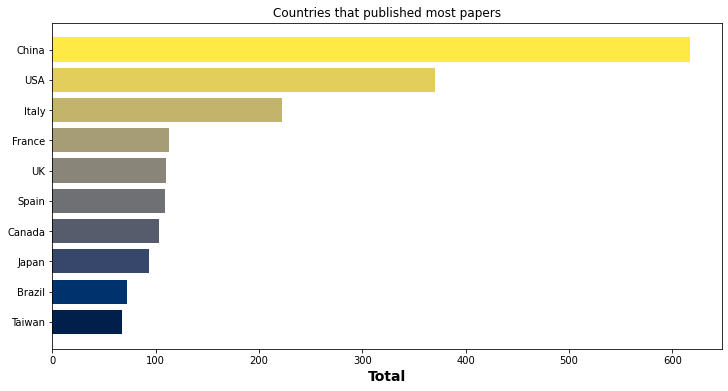

In [18]:
f, ax = plt.subplots(figsize=(12, 6))
idx = 9

ax.barh(sorted_countries.index[idx::-1], sorted_countries.values[idx::-1],
        color=palette.cividis(idx+1) )
ax.set_xlabel('Total', fontsize=14, fontweight="bold")
ax.set_title('Countries that published most papers')

plt.show()

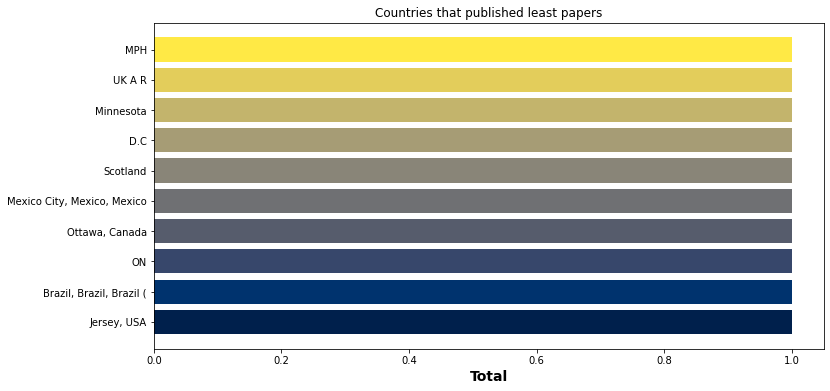

In [19]:
f, ax = plt.subplots(figsize=(12, 6))
idx = 10
num_countries = len(sorted_countries)

ax.barh(sorted_countries.index[num_countries-idx:num_countries],
        sorted_countries.values[num_countries-idx:num_countries],
        color=palette.cividis(idx) )
ax.set_xlabel('Total', fontsize=14, fontweight="bold")
ax.set_title('Countries that published least papers')

plt.show()

In [20]:
# GRIDSEARCH - TIME ANALYSIS

def compute_time_countries(n_workers, n_partitions):
    """
    Executes the above steps for a given number of @n_workers and @n_partitions.
    
    Return: computed_time
    """
    
    cluster = LocalCluster(n_workers = n_workers)
    client = Client(cluster) 
    
    start = time.time() 
        
    PATH = os.path.join('data', 'papers_in_json', '*.json')
    js = db.read_text(PATH).map(json.loads).repartition(n_partitions)
    
    authors = js.map(reformat).flatten().to_dataframe()
    
    countries = authors.groupby('country').author.count().compute() 
    sorted_countries = countries.sort_values(ascending=False) # Sorting in descending order
    
    end = time.time()
    
    client.close()
    cluster.close() 
    
    computed_time = end - start
    
    return computed_time

In [21]:
workers = [1, 2, 4, 8]
partitions = [1, 5, 25, 50, 75, 100]

times_c = []

for w in tqdm(workers):
    for p in tqdm(partitions):
        t = compute_time_countries(n_workers = w, n_partitions = p*w)
        times_c.append(t)
        print("Workers=", w, "Partitions=", p*w, "Time=", t,"s")

Workers= 1 Partitions= 1 Time= 40.305752754211426 s
Workers= 1 Partitions= 5 Time= 23.514246702194214 s
Workers= 1 Partitions= 25 Time= 21.288314819335938 s
Workers= 1 Partitions= 50 Time= 20.958200454711914 s
Workers= 1 Partitions= 75 Time= 21.62472939491272 s
Workers= 1 Partitions= 100 Time= 21.527350425720215 s



Workers= 2 Partitions= 2 Time= 19.722899436950684 s
Workers= 2 Partitions= 10 Time= 14.29028058052063 s
Workers= 2 Partitions= 50 Time= 13.496757507324219 s
Workers= 2 Partitions= 100 Time= 13.923191785812378 s
Workers= 2 Partitions= 150 Time= 13.93178915977478 s
Workers= 2 Partitions= 200 Time= 14.302764415740967 s



Workers= 4 Partitions= 4 Time= 11.10658884048462 s
Workers= 4 Partitions= 20 Time= 8.921771764755249 s
Workers= 4 Partitions= 100 Time= 9.19974660873413 s
Workers= 4 Partitions= 200 Time= 9.689058542251587 s
Workers= 4 Partitions= 300 Time= 10.546081304550171 s
Workers= 4 Partitions= 400 Time= 11.020403623580933 s



Workers= 8 Partitions= 8 Time= 7.410836219787598 s
Workers= 8 Partitions= 40 Time= 6.420297622680664 s
Workers= 8 Partitions= 200 Time= 7.496690988540649 s
Workers= 8 Partitions= 400 Time= 8.379846811294556 s
Workers= 8 Partitions= 600 Time= 8.962738513946533 s
Workers= 8 Partitions= 800 Time= 9.274219274520874 s




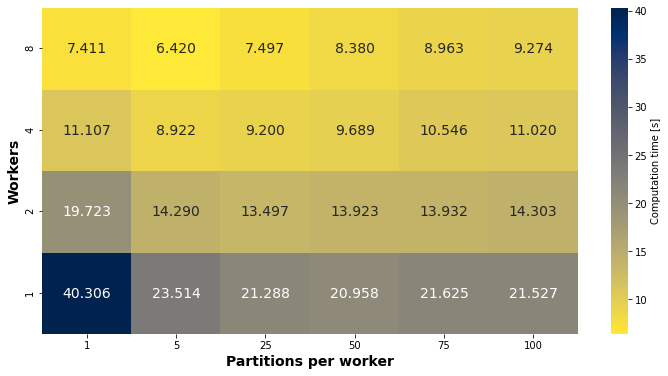

In [22]:
time_plot_countries = np.array(times_c).reshape(len(workers), len(partitions))

df_times_c = pd.DataFrame(time_plot_countries)

plt.figure(figsize=(12,6))

ax = sn.heatmap(df_times_c, annot=True, annot_kws={"size": 14},fmt=".3f",
                xticklabels=partitions, yticklabels=workers,
                cbar_kws={'label':'Computation time [s]'},cmap='cividis_r' )
ax.invert_yaxis()
ax.set_ylabel("Workers", fontsize=14, fontweight='bold')
ax.set_xlabel("Partitions per worker", fontsize=14, fontweight='bold')

plt.show()

Increasing the number of workers improves the performance, and the optimal number of partitions is again found to be between $5$ and $25$.

In [23]:
# Group by institution and then count. We select the author column aribitrarly, 
#to have just a single-column serie

universities = authors.groupby('institution').author.count().compute()
sorted_uni = universities.sort_values(ascending=False) # Sorting in descending order
sorted_uni = sorted_uni.drop("Missing")

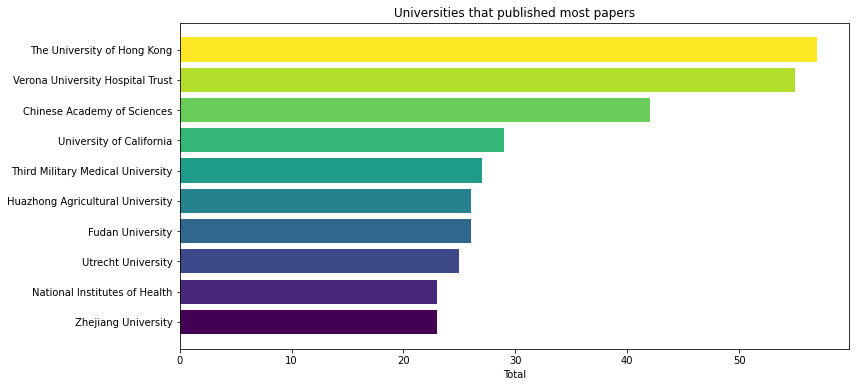

In [24]:
f, ax = plt.subplots(figsize=(12, 6))

idx = 9

ax.barh(sorted_uni.index[idx::-1], sorted_uni.values[idx::-1],
        color=palette.viridis(idx+1) )
ax.set_xlabel('Total')
ax.set_title('Universities that published most papers')

plt.show()

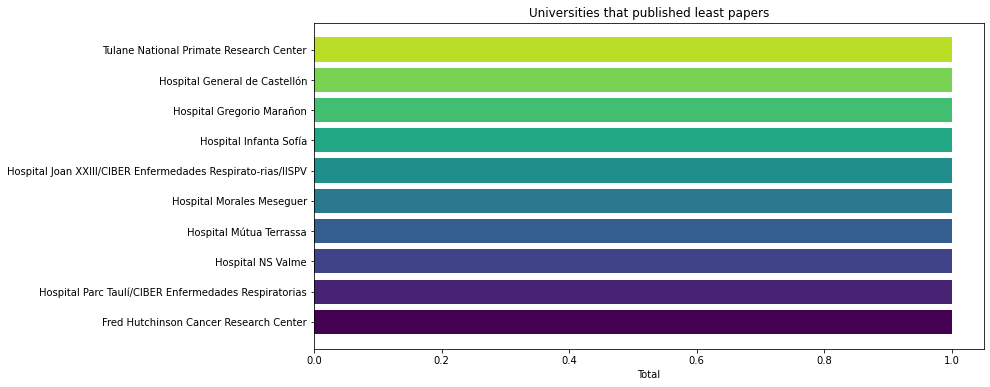

In [25]:
f, ax = plt.subplots(figsize=(12, 6))

idx = 10
num_uni = len(sorted_uni)

ax.barh(sorted_uni.index[num_uni-idx:num_uni], sorted_uni.values[num_uni-idx:num_uni],
        color=palette.viridis(idx+1) )
ax.set_xlabel('Total')
ax.set_title('Universities that published least papers')

plt.show()

In [26]:
# GRIDSEARCH - TIME ANALYSIS

def compute_time_uni(n_workers, n_partitions):
    """
    Executes the above steps for a given number of @n_workers and @n_partitions.
    
    Return: computed_time
    """
    
    cluster = LocalCluster(n_workers = n_workers)
    client = Client(cluster) 
    
    start = time.time() 
        
    PATH = os.path.join('data', 'papers_in_json', '*.json')
    js = db.read_text(PATH).map(json.loads).repartition(n_partitions)
    
    authors = js.map(reformat).flatten().to_dataframe()
    
    universities = authors.groupby('institution').author.count().compute()
    sorted_uni = universities.sort_values(ascending=False) # Sorting in descending order

    end = time.time()
    
    client.close()
    cluster.close() 
    
    computed_time = end - start
    
    return computed_time

In [27]:
workers = [1, 2, 4, 8]
partitions = [1, 5, 25, 50, 75, 100]

times_u = []

for w in workers:
    for p in partitions:
        t = compute_time_uni(n_workers = w, n_partitions = p*w)
        times_u.append(t)
        print("Workers=", w, "Partitions=", p*w, "Time=", t,"s")

Workers= 1 Partitions= 1 Time= 40.729756593704224 s
Workers= 1 Partitions= 5 Time= 24.371143102645874 s
Workers= 1 Partitions= 25 Time= 21.453698873519897 s
Workers= 1 Partitions= 50 Time= 21.845311880111694 s
Workers= 1 Partitions= 75 Time= 22.45706057548523 s
Workers= 1 Partitions= 100 Time= 22.171048879623413 s
Workers= 2 Partitions= 2 Time= 20.384233713150024 s
Workers= 2 Partitions= 10 Time= 14.632376909255981 s
Workers= 2 Partitions= 50 Time= 14.33906888961792 s
Workers= 2 Partitions= 100 Time= 15.07004451751709 s
Workers= 2 Partitions= 150 Time= 14.381082773208618 s
Workers= 2 Partitions= 200 Time= 15.792287349700928 s
Workers= 4 Partitions= 4 Time= 12.722763776779175 s
Workers= 4 Partitions= 20 Time= 9.617295265197754 s
Workers= 4 Partitions= 100 Time= 9.904065132141113 s
Workers= 4 Partitions= 200 Time= 10.554860830307007 s
Workers= 4 Partitions= 300 Time= 12.22231912612915 s
Workers= 4 Partitions= 400 Time= 12.781920433044434 s
Workers= 8 Partitions= 8 Time= 9.48272442817688 

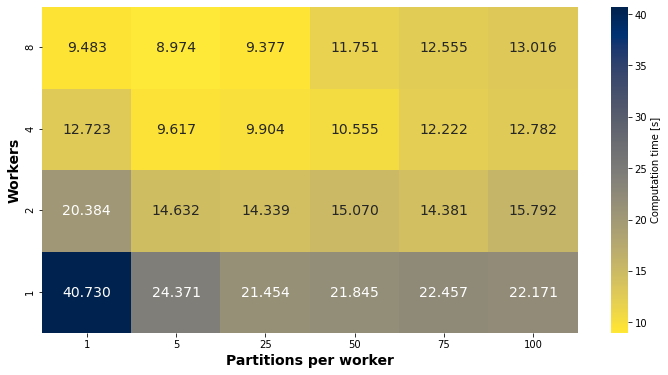

In [28]:
time_plot_uni = np.array(times_u).reshape(len(workers), len(partitions))

df_times_u = pd.DataFrame(time_plot_uni)

plt.figure(figsize=(12,6))

ax = sn.heatmap(df_times_u, annot=True, annot_kws={"size": 14},fmt=".3f",
                xticklabels=partitions, yticklabels=workers,
                cbar_kws={'label':'Computation time [s]'},cmap='cividis_r' )
ax.invert_yaxis()
ax.set_ylabel("Workers", fontsize=14, fontweight='bold')
ax.set_xlabel("Partitions per worker", fontsize=14, fontweight='bold')

plt.show()

In [29]:
client.close()

## Embedding for the title of the papers
In NLP a common technique to perform analysis over a set of texts is to transform the text into a set of vectors, each one representing a word inside a document. At the end of the pre-processing, the document will be transformed into a list of vectors, or a matrix $n\times m$ where $n$ is the number of words in the document and $m$ is the size of the vector that represents each word. More information about word-embedding: https://towardsdatascience.com/introductionto-word-embedding-and-word2vec-652d0c2060fa

What you can do is to transform the **title** of each paper into its embedding version by using the pre-trained model available on the FastText page: https://fasttext.cc/docs/en/pretrainedvectors.html.
The pre-trained model that you have to download is the https://dl.fbaipublicfiles.com/fasttext/vectorswiki/wiki.en.vec

Basically the pre-trained model is more or less a huge dictionary in the following format `key: vector`. 

To load the model, follow the snippet of code which is slightly different from what you can find at this page: https://fasttext.cc/docs/en/english-vectors.html

In [30]:
def load_wordlist(fname):
    words = {}
    
    with io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore') as fin:
        n, d = map(int, fin.readline().split())
        # n = number of words
        # d = vector dimension
        
        embeddings = np.zeros((n, d), dtype=np.float32)
        
        with tqdm(total=n) as pbar:
            for i, line in enumerate(fin):
                tokens = line.rstrip().split(' ')
                words[tokens[0]] = i
                embeddings[i, :] = np.array(tokens[1:], dtype=np.float32) 
                
                pbar.update(1)
                
        return words, embeddings

In [31]:
path_to_model = "/media/einlar/Windows1/JDownloads/"
wordlist, embeddings = load_wordlist(path_to_model + 'wiki.en.vec')

Once you have downloaded the model, use the map approach to create a DataFrame or a Bag that is composed by:
- `paper-id`
- `title-embedding`

The title embedding can be a list of vectors or can be flattened to a large vector.

In [32]:
client = Client(processes=False) #multithreaded mode (not multiprocessing)
client

Client Scheduler: inproc://192.168.42.29/28708/1 Dashboard: http://192.168.42.29:8787/status,Cluster Workers: 1 Cores: 16 Memory: 16.82 GB


In [33]:
PATH = os.path.join('data', 'papers_in_json', '*.json')

js = db.read_text(PATH).map(json.loads)

d = 300 #dimension of vectors (read from file)

def get_embedding(title):
    """
    Given a @title, returns a matrix such that each row is the embedding vector
    of a word in it.
    """
    
    words = title.split()
    
    title_embedding = []
    
    for i, word in enumerate(title):
        word_index = wordlist.get(word, -1)
        
        if word_index != -1:
            title_embedding.append(embeddings[word_index])
    
    return np.array(title_embedding)

def extract_title_embeddings(paper):
    """
    Extracts the "paper_id" and the title embedding for a given @paper.
    """
    
    title = sanitize_string(paper['metadata']['title'])
    title = title.replace("journal preproof", "")
    
    return {'paper_id' : paper['paper_id'], 'title-embedding' : get_embedding(title)}

def extract_title(paper):
    """
    Extracts the "paper_id" and the title for a given @paper.
    """
    
    title = sanitize_string(paper['metadata']['title'])
    title = title.replace("journal preproof", "")
    
    return {'paper_id' : paper['paper_id'], 'title-embedding' : title}

In [34]:
titles = js.map(extract_title_embeddings)
all_embeddings = titles.compute()
all_embeddings 

[{'paper_id': '000a0fc8bbef80410199e690191dc3076a290117',
  'title-embedding': array([[ 0.019006,  0.15585 ,  0.11008 , ..., -0.07909 ,  0.039304,
           0.041258],
         [-0.21327 , -0.39156 ,  0.1885  , ..., -0.07631 ,  0.28404 ,
           0.27578 ],
         [ 0.038464, -0.11291 , -0.17323 , ...,  0.18243 , -0.071865,
           0.094051],
         ...,
         [-0.31913 , -0.25218 ,  0.42204 , ...,  0.44076 ,  0.31126 ,
          -0.2409  ],
         [ 0.26386 , -0.07325 ,  0.037621, ...,  0.23706 , -0.45787 ,
           0.051434],
         [-0.089375,  0.14391 ,  0.10134 , ..., -0.019988,  0.17858 ,
           0.1463  ]], dtype=float32)},
 {'paper_id': '000affa746a03f1fe4e3b3ef1a62fdfa9b9ac52a',
  'title-embedding': array([[-0.013152, -0.29961 ,  0.12982 , ...,  0.17816 ,  0.24468 ,
           0.21235 ],
         [-0.23323 , -0.27436 , -0.10449 , ...,  0.058304,  0.24731 ,
           0.31659 ],
         [-0.31913 , -0.25218 ,  0.42204 , ...,  0.44076 ,  0.31126 ,
        

**Bonus point**
Use the previously generated vectors to compute the **cosine similarity** between each paper and to figure out a couple of papers with the highest cosine similarity score. This point is a bonus/optional point.

In [35]:
def cosine_similarity(a, b):
    return np.dot(a, b) / ( np.linalg.norm(a) * np.linalg.norm(b) )

N_papers = len(all_embeddings)

def get_similarities(paper):
    """
    Returns a vector of length N_papers with the cosine similarity between @paper and all
    the other ones.
    """
    
    a_embedding = paper["title-embedding"].flatten()
    a_embedding_length = len(a_embedding)
    
    similarities = np.zeros(N_papers, dtype=np.float32)
    
    for i, p in enumerate(all_embeddings):
        b_embedding = p["title-embedding"].flatten()
        common_length = min(a_embedding_length, len(b_embedding))
        
        similarities[i] = cosine_similarity(a_embedding[:common_length],
                                            b_embedding[:common_length])
    
    return similarities

In [36]:
similarities = db.from_sequence(all_embeddings).map(get_similarities)

In [37]:
similarities = np.array(similarities.compute()) 
similarities[np.isnan(similarities)] = 0 #remove NaNs
similarities[np.diag_indices(len(similarities))] = 0 #remove diagonal

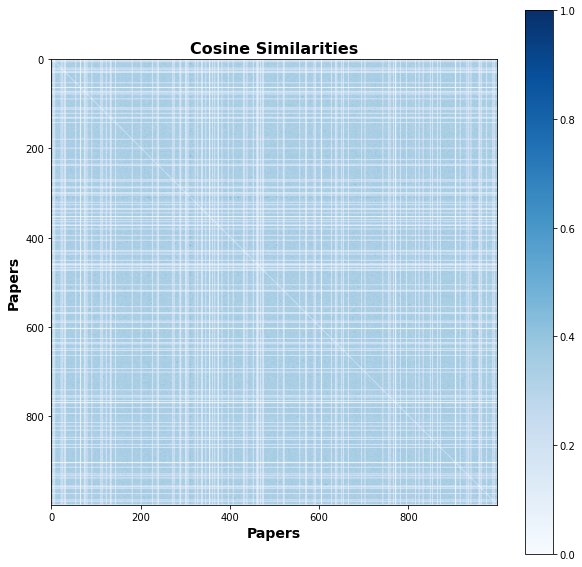

In [38]:
fig, ax = plt.subplots(figsize=(10,10))

ax.set_xlabel("Papers", fontsize=14, fontweight="bold")
ax.set_ylabel("Papers", fontsize=14, fontweight="bold")
ax.set_title("Cosine Similarities", fontsize=16, fontweight="bold")
heatmap = ax.imshow(similarities, cmap='Blues')
fig.colorbar(heatmap, ax=ax)

plt.show()

In [42]:
all_titles = js.map(extract_title).to_dataframe().compute()

In [44]:
#Print some examples
sorted_similarities = np.argsort(-similarities, axis=None) #decreasing order
sorted_indices = np.unravel_index(sorted_similarities, similarities.shape)

num = 0
i = 0

while num < 40:
    a_ind = sorted_indices[0][i]
    b_ind = sorted_indices[1][i]
    i += 1
    
    if (a_ind < b_ind):
        continue
    
    a = all_embeddings[a_ind]['paper_id']
    b = all_embeddings[b_ind]['paper_id']
    
    a_title = all_titles.loc[all_titles['paper_id'] == a]['title-embedding'][0]
    b_title = all_titles.loc[all_titles['paper_id'] == b]['title-embedding'][0]
    
    sim = similarities[a_ind, b_ind]
    
    print(num, ':')
    print("A: {};\nB: {}\nSimilarity: {:.2f}".format(a_title, b_title, sim))
    print('----')
    
    num += 1

0 :
A: original article;
B: original article
Similarity: 1.00
----
1 :
A: editorial perspective perils promise child adolescent sleep associated psychopathology covid19 pandemic;
B: editorial
Similarity: 1.00
----
2 :
A: supplementary appendix preparedness vulnerability african countries importations covid19 modelling study;
B: supplementary appendix
Similarity: 1.00
----
3 :
A: role cd25cd4t cells acute persistent coronavirus infection central nervous system;
B: role cd25cd4t cells acute persistent coronavirus infection central nervous system
Similarity: 1.00
----
4 :
A: supplementary appendix;
B: supplementary appendix evolving epidemiology transmission dynamics coronavirus disease outside hubei province china descriptive modelling study supplementary appendix
Similarity: 1.00
----
5 :
A: comment;
B: comment nature reviewsendocrinology
Similarity: 1.00
----
6 :
A: commentary covid19 patients diabetes;
B: comment
Similarity: 1.00
----
7 :
A: comment www;
B: comment
Similarity: 1.00
--